<b><h1 align=center>Lane Line Detection using Computer Vision</h1></b>  
<img src="https://github.com/udacity/CarND-LaneLines-P1/raw/master/examples/laneLines_thirdPass.jpg" width="480" alt="Combined Image" />
## Overview  
When we drive, we use our eyes to decide where to go. The lines on the road that show us where the lanes are act as our constant reference for where to steer the vehicle. Naturally, one of the first things we would like to do in developing a self-driving car is to automatically detect lane lines using an algorithm.

In this project you will detect lane lines in images using Python and OpenCV. OpenCV means "Open-Source Computer Vision", which is a package that has many useful tools for analyzing images.  
  
**The tools we have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection. Our goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display. Once we have a working pipeline, we will try it out on the video stream.**  
  
  
  
Source: [Udacity](https://udacity.com)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

/kaggle/input/test-img/Eastern Delhi Expressway.png
/kaggle/input/indian-roads/Driving on Delhi Eastern Peripheral Expressway (NE II) - India 1m35s - 1m48.7s (M8M9Iv63WxU).mp4


## Get the required Images and Videos  
Credits: [Udacity Self-Driving Car Nanodegree GitHub Repository](https://github.com/udacity/CarND-LaneLines-P1)

In [2]:
!git clone https://github.com/udacity/CarND-LaneLines-P1.git

Cloning into 'CarND-LaneLines-P1'...
remote: Enumerating objects: 254, done.
remote: Total 254 (delta 0), reused 0 (delta 0), pack-reused 254
Receiving objects: 100% (254/254), 43.45 MiB | 26.98 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [3]:
from distutils.dir_util import copy_tree
import shutil
copy_tree("./CarND-LaneLines-P1/test_images", "./test_images")
copy_tree("./CarND-LaneLines-P1/test_videos", "./test_videos")
shutil.rmtree('./CarND-LaneLines-P1', ignore_errors=False, onerror=None)

# 1. Color Selection  
First let us select some colors. For Instance: Lane Lines are usually **White** in color and we know the RGB value of White is (255,255,255). Here we will define a color threshold in the variables **red_threshold**, **green_threshold**, and **blue_threshold** and populate **rgb_threshold** with these values. This vector contains the minimum values for red, green, and blue (R,G,B) that I will allow in my selection.

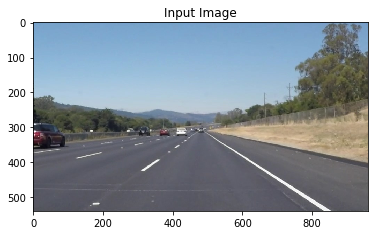

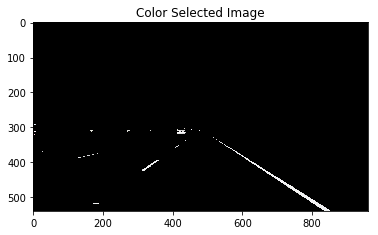

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)

# Define color selection criteria
###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 200
green_threshold = 200
blue_threshold = 200
######

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Do a boolean or with the "|" character to identify
# pixels below the thresholds
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

# Display the image
plt.imshow(image)
plt.title("Input Image")
plt.show()
plt.imshow(color_select)
plt.title("Color Selected Image")
plt.show()

# Uncomment the following code if you are running the code locally and wish to save the image
# mpimg.imsave("test-after.jpg", color_select)

**In the above output we can clearly see the lane lines**

# 2. Region Masking  
I'll assume that the front facing camera that took the image is mounted in a fixed position on the car, such that the lane lines will always appear in the same general region of the image. Next, I'll take advantage of this by adding a criterion to only consider pixels for color selection in the region where we expect to find the lane lines.

Check out the code below. The variables **left_bottom**, **right_bottom**, and **apex** represent the vertices of a **triangular region** that I would like to retain for my color selection, while masking everything else out. Here I'm using a triangular mask to illustrate the simplest case, but we can use a quadrilateral, and in principle, we could use any polygon.

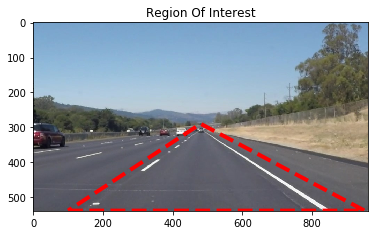

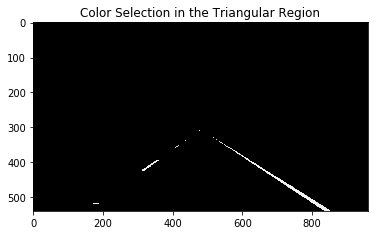

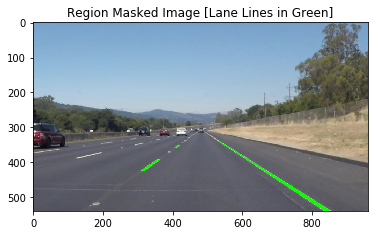

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
line_image = np.copy(image)

# Define color selection criteria
# MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 200
green_threshold = 200
blue_threshold = 200

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define the vertices of a triangular mask.
# Keep in mind the origin (x=0, y=0) is in the upper left
# MODIFY THESE VALUES TO ISOLATE THE REGION 
# WHERE THE LANE LINES ARE IN THE IMAGE
left_bottom = [100, 539]
right_bottom = [950, 539]
apex = [480, 290]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
                    
# Mask color and region selection
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
line_image[~color_thresholds & region_thresholds] = [9, 255, 0]

# Display the image and show region and color selections
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'r--', lw=4)
plt.title("Region Of Interest")
plt.show()
plt.imshow(color_select)
plt.title("Color Selection in the Triangular Region")
plt.show()
plt.imshow(line_image)
plt.title("Region Masked Image [Lane Lines in Green]")
plt.show()

# Yeah! We've successfully detected the Lane Lines (Really ?)
## Check the below test.

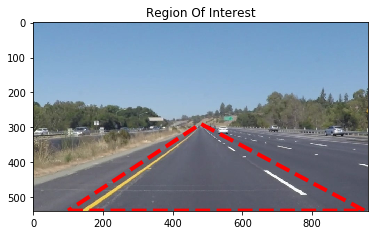

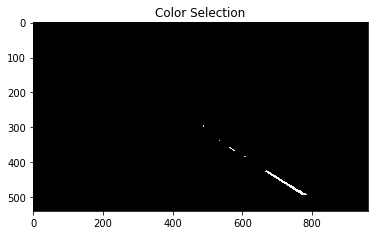

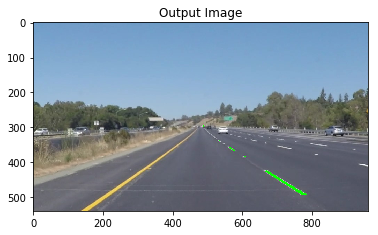

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image
image = mpimg.imread('test_images/solidYellowLeft.jpg')

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
line_image = np.copy(image)

# Define color selection criteria
# MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 200
green_threshold = 200
blue_threshold = 200

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define the vertices of a triangular mask.
# Keep in mind the origin (x=0, y=0) is in the upper left
# MODIFY THESE VALUES TO ISOLATE THE REGION 
# WHERE THE LANE LINES ARE IN THE IMAGE
left_bottom = [100, 539]
right_bottom = [950, 539]
apex = [480, 290]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
                    
# Mask color and region selection
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
line_image[~color_thresholds & region_thresholds] = [9, 255, 0]

# Display the image and show region and color selections
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'r--', lw=4)
plt.title("Region Of Interest")
plt.show()
plt.imshow(color_select)
plt.title("Color Selection")
plt.show()
plt.imshow(line_image)
plt.title("Output Image")
plt.show()

## Opps! We got a yellow line [undetected] here. Let's fix this up.

# 3. Canny Edge Detection  
Now we are applying **Canny** to the gray-scaled image and our output will be another image called edges. **low_threshold** and **high_threshold** are your **thresholds for edge detection**.

The algorithm will first detect strong **edge** (strong gradient) pixels above the **high_threshold**, and reject pixels below the **low_threshold**. Next, pixels with values between the **low_threshold** and **high_threshold** will be included as long as they are connected to strong edges. **The output edges is a binary image with white pixels tracing out the detected edges and black everywhere else**. See the [OpenCV Canny Docs](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html) for more details.

**What would make sense as a reasonable range for these parameters?** In our case, converting to grayscale has left us with an 8-bit image, so each pixel can take 2^8 = 256 possible values. Hence, the pixel values range from 0 to 255.

This range implies that **derivatives** (essentially, the value differences from pixel to pixel) will be on the scale of tens or hundreds. So, a reasonable range for your threshold parameters would also be in the tens to hundreds.

As far as a ratio of **low_threshold** to **high_threshold**, **[John Canny](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html#steps) himself recommended a low to high ratio of 1:2 or 1:3.**

We'll also include **Gaussian smoothing**, before running **Canny**, which is **essentially a way of suppressing noise and spurious gradients by averaging (check out the OpenCV docs for GaussianBlur). cv2.Canny() actually applies Gaussian smoothing internally, but we include it here because you can get a different result by applying further smoothing (and it's not a changeable parameter within cv2.Canny()!).****

You can choose the **kernel_size** for Gaussian smoothing to be any odd number. **A larger kernel_size implies averaging, or smoothing, over a larger area.**

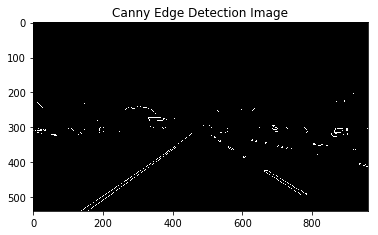

In [7]:
# Do all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in the image and convert to grayscale
# Note: in the previous example we were reading a .jpg 
# Here we read a .png and convert to 0,255 bytescale
image = mpimg.imread('test_images/solidYellowLeft.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
kernel_size = 5 # Must be an odd number (3, 5, 7...)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and run it
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')
plt.title("Canny Edge Detection Image")
plt.show()

# 4. Hough Transform and detecting Lane Lines  
## Hough Transform 
In image space, a line is plotted as x vs. y, but in 1962, Paul Hough devised a method for representing lines in parameter space, which we will call “Hough space” in his honor.

In Hough space, I can represent my "x vs. y" line as a point in "m vs. b" instead. The Hough Transform is just the conversion from image space to Hough space. So, the characterization of a line in image space will be a single point at the position (m, b) in Hough space. References [Click Here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)

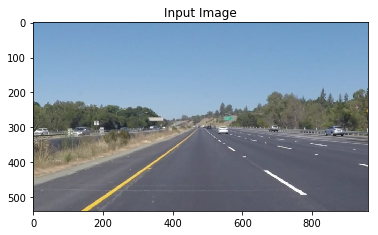

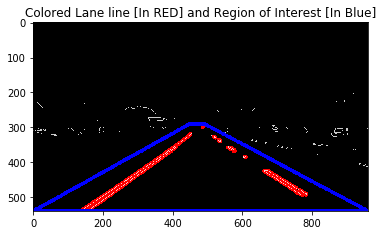

In [8]:
# Read in and grayscale the image
image = mpimg.imread('test_images/solidYellowLeft.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 2     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 4 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
lines_edges = cv2.polylines(lines_edges,vertices, True, (0,0,255), 10)
plt.imshow(image)
plt.title("Input Image")
plt.show()
plt.imshow(lines_edges)
plt.title("Colored Lane line [In RED] and Region of Interest [In Blue]")
plt.show()

# Congratulations! We've successfully detected Lane Lines from different images using OpenCV. (No Deep Learning :-))

# 5. Let's Make a Lane Detection Pipeline  
1. Gray Scale
2. Gaussian Smoothing
3. Canny Edge Detection
4. Region Masking
5. Hough Transform
6. Draw Lines [Mark Lane Lines with different Color]

In [9]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def slope_lines(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #print(left_line, right_line)

    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)

        #we know that equation of line is y=mx +c so we can write it x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)
    
    #cv2.polylines(img,np.array([poly_vertices],'int32'), True, (0,0,255), 10)
    #print(poly_vertices)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    line_img = slope_lines(line_img,lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    #lines_edges = cv2.polylines(lines_edges,get_vertices(img), True, (0,0,255), 10)
    return lines_edges
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [10]:
# Lane finding Pipeline
def lane_finding_pipeline(image):
    
    #Grayscale
    gray_img = grayscale(image)
    #Gaussian Smoothing
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    #Canny Edge Detection
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #Masked Image Within a Polygon
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    #Hough Transform Lines
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #Draw lines on edges
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    
    return output

# Test our Algorithm Pipeline with different Images

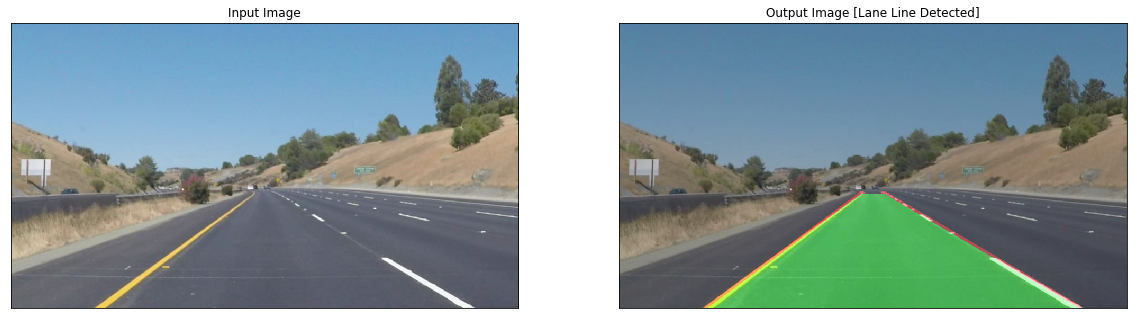

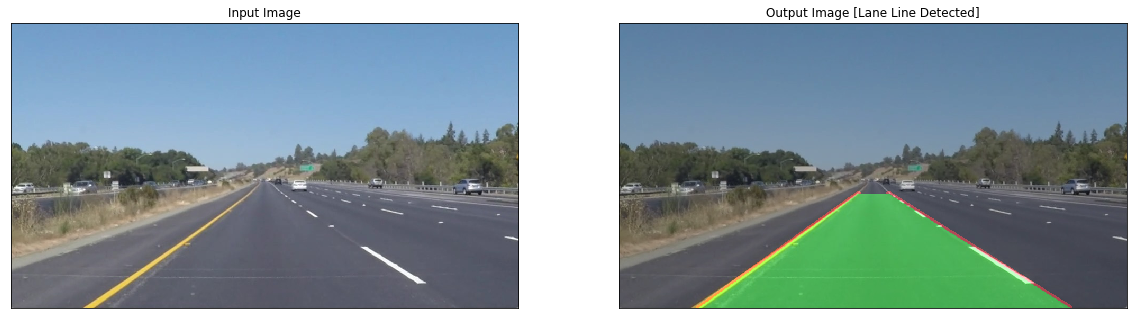

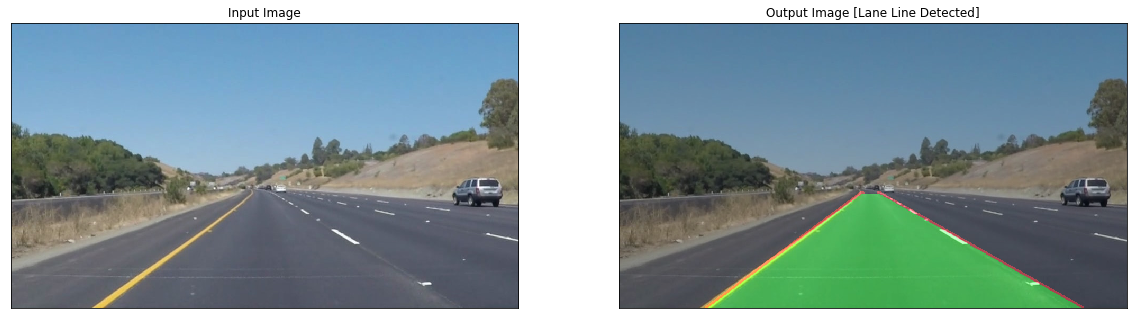

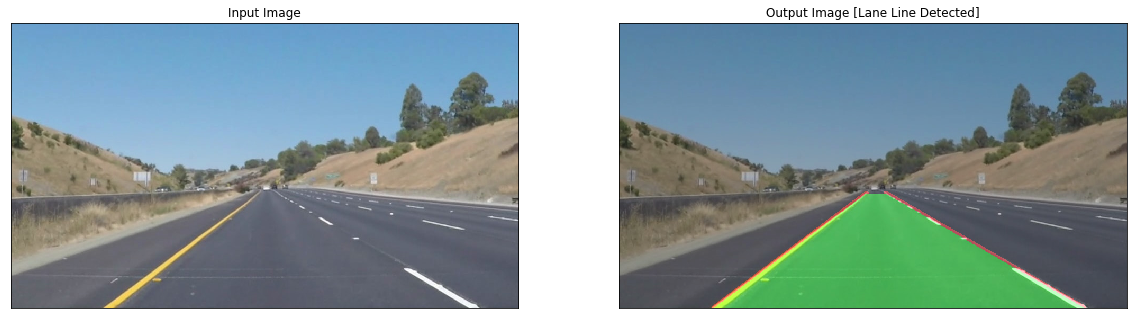

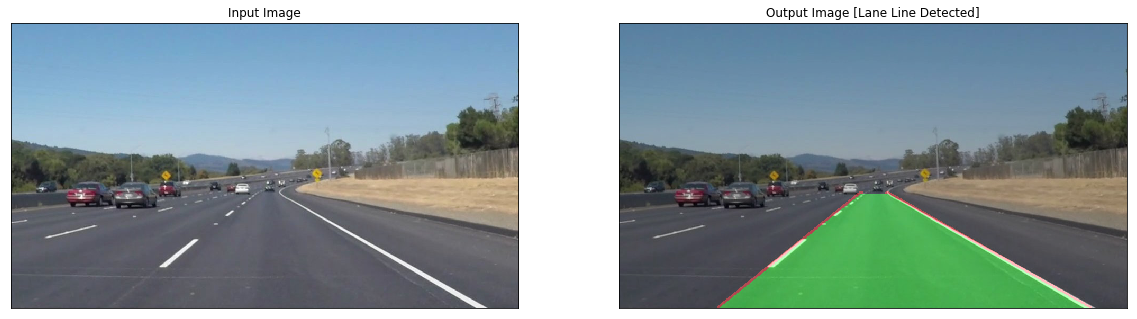

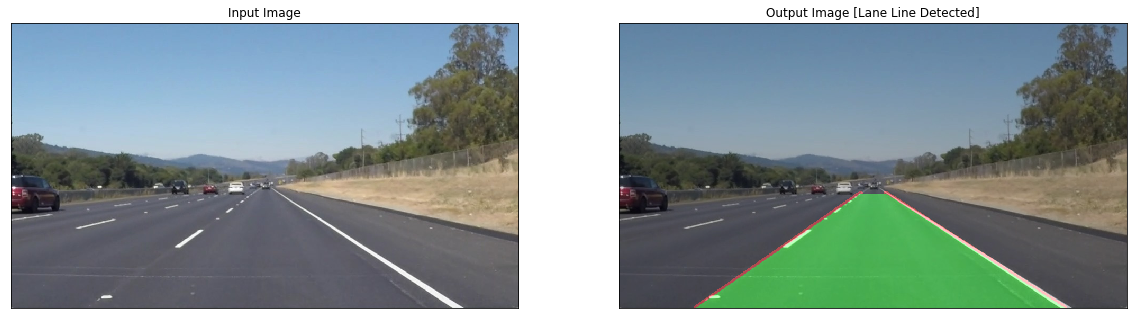

In [11]:
for image_path in list(os.listdir('./test_images')):
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./test_images/{image_path}')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input Image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(lane_finding_pipeline(image))
    ax.set_title("Output Image [Lane Line Detected]")
    plt.show()

## Test on Eastern Delhi Expressway

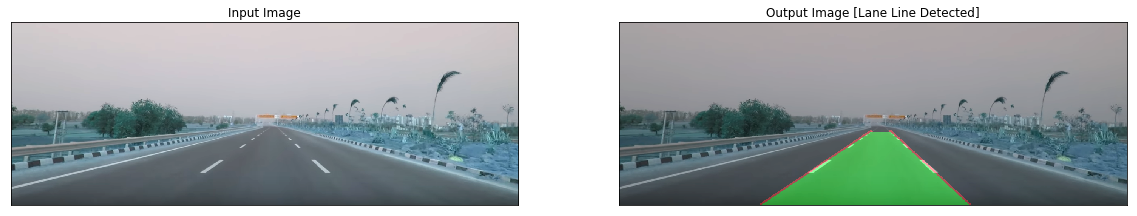

In [12]:
fig = plt.figure(figsize=(20, 10))
image = mpimg.imread('../input/test-img/Eastern Delhi Expressway.png')
image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
image *= 255/image.max() 
image = image.astype(np.uint8)
ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
plt.imshow(image)
ax.set_title("Input Image")
ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
plt.imshow(lane_finding_pipeline(image))
ax.set_title("Output Image [Lane Line Detected]")
plt.show()

# 6. Let's try with Video Stream [Yes! Real-time Lane Line Detection]

*Install moviepy package*

In [13]:
!pip install moviepy

     |████████████████████████████████| 399kB 3.9MB/s 
     |████████████████████████████████| 22.2MB 41.4MB/s 
  Created wheel for moviepy: filename=moviepy-1.0.0-cp36-none-any.whl size=131367 sha256=608e0ab2c0de09e4048d5fa80a3f99badc341693ddd15935ec2e92202451ae00
  Stored in directory: /tmp/.cache/pip/wheels/52/e2/4c/f594a5945bc98e052ef248b46a0f1f7ea838b0b2a5f8895651
  Created wheel for proglog: filename=proglog-0.1.9-cp36-none-any.whl size=6149 sha256=178c16228d70c65627d987584d10a3fc9a447d2f99ef32b5ac6e229e7e2aa852
  Stored in directory: /tmp/.cache/pip/wheels/65/56/60/1d0306a8d90b188af393c1812ddb502a8821b70917f82dcc00
Successfully built moviepy proglog


In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
# !wget -O "test_videos/jaipurHighway.mp4" "https://r6---sn-gwpa-ccpe.googlevideo.com/videoplayback?expire=1567196271&ei=DzBpXcq8Bs6k1gKvvp_IBg&ip=185.172.110.235&id=o-AJgxIMoUEuKDGJuLvFDwCoVO-YFXJIv-63q28E5_-tuR&itag=137&aitags=133,134,135,136,137,160,242,243,244,247,248,271,278&source=youtube&requiressl=yes&mime=video/mp4&gir=yes&clen=290548152&dur=605.233&lmt=1530245281069433&fvip=6&keepalive=yes&c=WEB&sparams=expire,ei,ip,id,aitags,source,requiressl,mime,gir,clen,dur,lmt&sig=ALgxI2wwRAIgK8XLsUt8Wep20jakCHAkIuLXvss_9xmrjYo1bLouuKQCIDkKYeQn5jmmtnOe1lUV2IxL0dFYnwu5Gs51cATjK38c&title=&redirect_counter=1&rm=sn-5hnes77e&req_id=3a264db9667ba3ee&cms_redirect=yes&ipbypass=yes&mip=2409:4062:2396:e5fe:4403:883f:7067:3510&mm=31&mn=sn-gwpa-ccpe&ms=au&mt=1567175087&mv=m&mvi=5&pl=36&lsparams=ipbypass,mip,mm,mn,ms,mv,mvi,pl&lsig=AHylml4wRQIgEyH_i_cWEcUkxdxJmn23UlcBFXEDgElDaFsMN2WPB8sCIQD5fWqZ19kCQTPncHL3uhVfmYkLGu9jDq7ZJ3Tljk8b_w=="

## **Test with Video Clip 1 [Solid White Lane Lines]**

In [16]:
white_output = './solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/jaipurHighway.mp4").subclip(50,60)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(lane_finding_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   3%|▎         | 7/221 [00:00<00:03, 66.69it/s, now=None]

Moviepy - Building video ./solidWhiteRight.mp4.
Moviepy - Writing video ./solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready ./solidWhiteRight.mp4
CPU times: user 4.34 s, sys: 444 ms, total: 4.78 s
Wall time: 6.56 s


### **Output Video**

In [17]:
HTML("""
<video width="960" height="500" controls>
  <source src="{0}">
</video>
""".format(white_output))

## **Test with Video Clip 2 [With Yellow Lane Lines]**

In [18]:
yellow_output = './solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(lane_finding_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./solidYellowLeft.mp4.
Moviepy - Writing video ./solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready ./solidYellowLeft.mp4
CPU times: user 13.1 s, sys: 872 ms, total: 14 s
Wall time: 18.7 s


### **Output**

In [19]:
HTML("""
<video width="960" height="500" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## **Shortcomings**  
**1. Hough Transform is fit for Straight Lines only but in reality curved lane lines exists where this will fail.**   
**2. There are many roads which don't have lane markings where this will fail.**

**References:**  
1. [Udacity Self-Driving Car Nanodegree](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd013)  
2. [Finding Lane Lines — Simple Pipeline For Lane Detection](https://towardsdatascience.com/finding-lane-lines-simple-pipeline-for-lane-detection-d02b62e7572b)

## **Thank you for your time. Feel free to drop your comments and suggestions for further improvements and discussions**

### **Author: [Soumya Ranjan Behera](https://linkedin.com/in/soumya044)**  
[Let's Connect](https://linkedin.com/in/soumya044)